# PSTAT235 Team Assignment -Group 28

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import split, explode
from pyspark.sql.types import IntegerType

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("Voter Data Analysis").getOrCreate()

In [207]:
# load AZ data
bucket_dir="gs://pstat135-voter-file/VM2Uniform/"
df = spark.read.parquet(bucket_dir + 'VM2Uniform--AZ--2021-05-20')

In [3]:
# Read MA data
dfma = spark.read.parquet(bucket_dir + 'VM2Uniform--MA--2021-01-19')

In [4]:
# load ND data
dfnd = spark.read.parquet(bucket_dir + 'VM2Uniform--ND--2021-03-18')

## Arizona

In [5]:
# the total records output
df.count()

4266400

In [6]:
df.printSchema()

root
 |-- SEQUENCE: string (nullable = true)
 |-- LALVOTERID: string (nullable = true)
 |-- Voters_Active: string (nullable = true)
 |-- Voters_StateVoterID: string (nullable = true)
 |-- Voters_CountyVoterID: string (nullable = true)
 |-- VoterTelephones_LandlineAreaCode: string (nullable = true)
 |-- VoterTelephones_Landline7Digit: string (nullable = true)
 |-- VoterTelephones_LandlineFormatted: string (nullable = true)
 |-- VoterTelephones_LandlineUnformatted: string (nullable = true)
 |-- VoterTelephones_LandlineConfidenceCode: string (nullable = true)
 |-- VoterTelephones_CellPhoneOnly: string (nullable = true)
 |-- VoterTelephones_CellPhoneFormatted: string (nullable = true)
 |-- VoterTelephones_CellPhoneUnformatted: string (nullable = true)
 |-- VoterTelephones_CellConfidenceCode: string (nullable = true)
 |-- Voters_FirstName: string (nullable = true)
 |-- Voters_MiddleName: string (nullable = true)
 |-- Voters_LastName: string (nullable = true)
 |-- Voters_NameSuffix: string (

In [208]:
# convert string columns to numeric 
df = df.withColumn(
    "ElectionReturns_G18CountyTurnoutAllRegisteredVoters", 
    regexp_replace(
        "ElectionReturns_G18CountyTurnoutAllRegisteredVoters", "%", ""
    ).cast(IntegerType())
)
df = df.withColumn(
    "CommercialData_EstimatedHHIncomeAmount", 
    expr(
        "substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))"
    ).cast(IntegerType())
)
df = df.withColumn(
    "CommercialData_EstHomeValue", 
    expr(
        "substring(CommercialData_EstHomeValue, 2, length(CommercialData_EstHomeValue))"
    ).cast(IntegerType())
)
df = df.withColumn("Voters_Age", df["Voters_Age"].cast(IntegerType()))

### Home value

In [209]:
# drop Null values and show statistical description 
homevalue_df = df.select("CommercialData_EstHomeValue").na.drop()

homevalue_df.describe(["CommercialData_EstHomeValue"]).show()

+-------+---------------------------+
|summary|CommercialData_EstHomeValue|
+-------+---------------------------+
|  count|                    4066567|
|   mean|          327062.0277528933|
| stddev|         227810.70554550044|
|    min|                       9499|
|    max|                    4997919|
+-------+---------------------------+



Text(0, 0.5, 'Frequency')

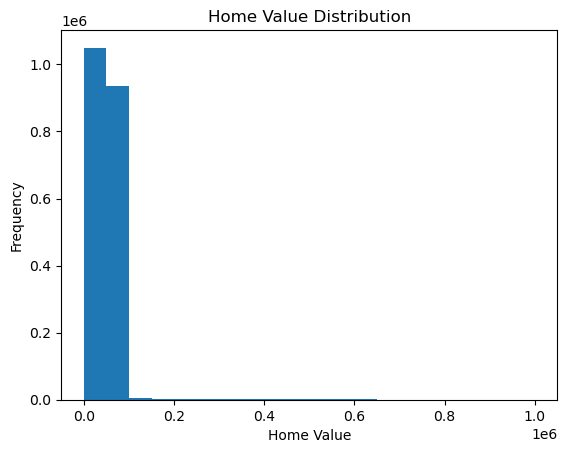

In [48]:
# Plot its distribution
data = homevalue_df.sort("CommercialData_EstHomeValue").toPandas()
plt.hist(data, bins=20)
plt.title('Home Value Distribution')
plt.xlabel('Home Value')
plt.ylabel('Frequency')

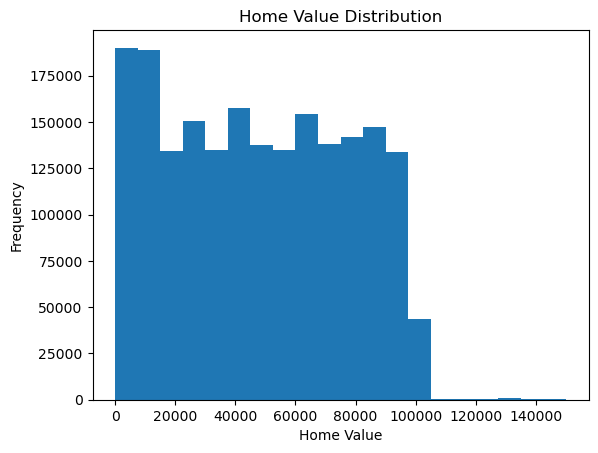

In [55]:
plt.hist(data.loc[data['CommercialData_EstHomeValue'] < 150000], bins=20)
plt.title('Home Value Distribution')
plt.xlabel('Home Value')
plt.ylabel('Frequency')
plt.show()

## Spatial distribution

In [210]:
from shapely.geometry import Point
import geopandas as gpd


data_path = "gs://pstat235-project-zw/"
# read shapefiles
counties_gdf = gpd.read_file(
    os.path.join(
        data_path, "shp/Counties.shp"
    )
)

In [211]:
def gen_state_gdf(df, state_name, counties_gdf=counties_gdf):
    voters_df = df.select(
        "Residence_Addresses_Longitude", "Residence_Addresses_Latitude"
    ).dropna()
    voters_pddf = voters_df.toPandas()
    voters_pddf = voters_pddf.astype(
        {
            "Residence_Addresses_Longitude": 'float',
            "Residence_Addresses_Latitude": 'float'
        }
    )
    print("voters_pddf created! Next: counties_in_state_gdf...")
    
    counties_in_state_gdf = counties_gdf.loc[counties_gdf["STATE_NAME"] == state_name]
    print("counties_in_state_gdf created! Next: voters_gdf...")
    
    # geodataframe of voters
    geometry = [
        Point(xy) for xy in zip(
            voters_pddf["Residence_Addresses_Longitude"], 
            voters_pddf["Residence_Addresses_Latitude"]
        )
    ]
    voters_gdf = gpd.GeoDataFrame(
        voters_pddf, crs="EPSG:4326", geometry=geometry
    )
    
    return voters_gdf, counties_in_state_gdf

In [7]:
az_voters_gdf, az_counties_in_state_gdf = gen_state_gdf(df, 'Arizona')

voters_pddf created! Next: counties_in_state_gdf...
counties_in_state_gdf created! Next: voters_gdf...


<AxesSubplot:>

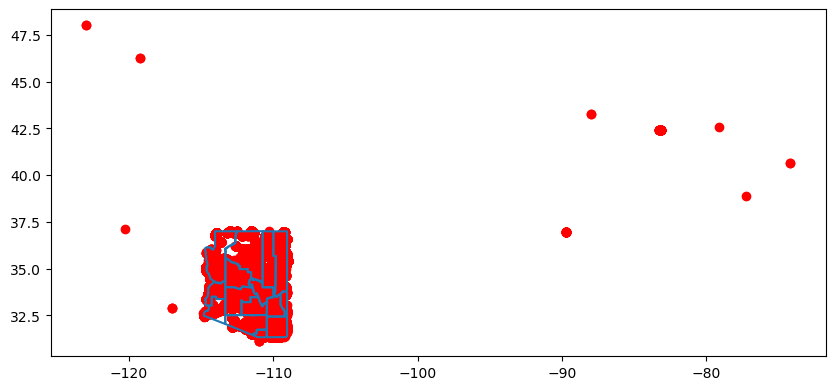

In [8]:
# plot
fig, ax = plt.subplots(figsize=(10, 6))
az_counties_in_state_gdf.boundary.plot(ax=ax)
az_voters_gdf.plot(ax=ax, color='red')
plt.show()

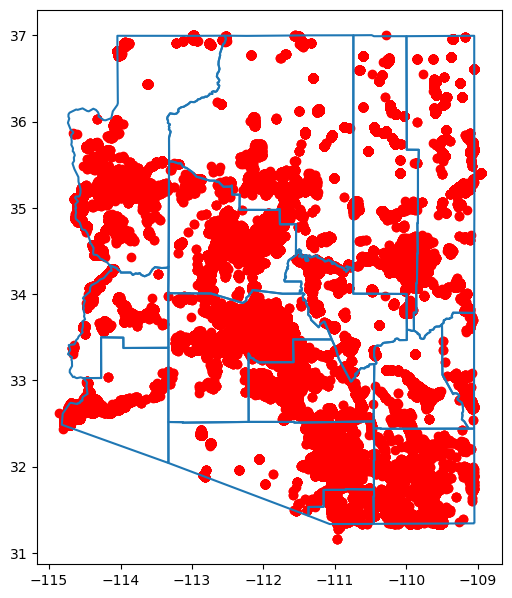

In [212]:
# remove outliers
az_voters_rmout_gdf = az_voters_gdf.loc[
    (az_voters_gdf["Residence_Addresses_Longitude"] > -116) &
    (az_voters_gdf["Residence_Addresses_Longitude"] < -105)
]

fig, ax = plt.subplots(figsize=(6, 8))
az_counties_in_state_gdf.boundary.plot(ax=ax)
az_voters_rmout_gdf.plot(ax=ax, color='red')
plt.show()

voters_pddf created! Next: counties_in_state_gdf...
counties_in_state_gdf created! Next: voters_gdf...


<AxesSubplot:>

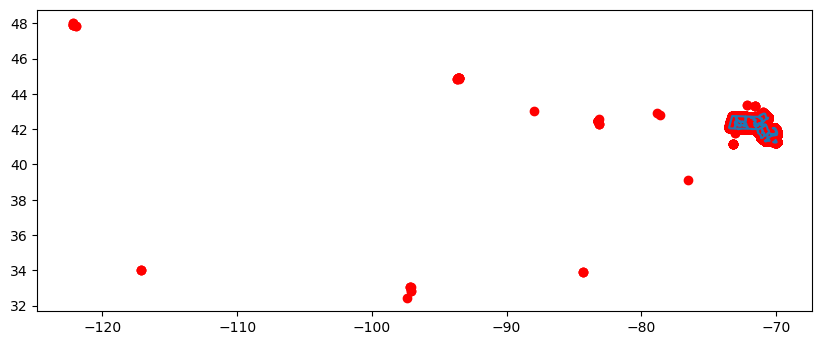

In [ ]:
ma_voters_gdf, ma_counties_in_state_gdf = gen_state_gdf(dfma, 'Massachusetts')

fig, ax = plt.subplots(figsize=(10, 6))
ma_counties_in_state_gdf.boundary.plot(ax=ax)
ma_voters_gdf.plot(ax=ax, color='red')

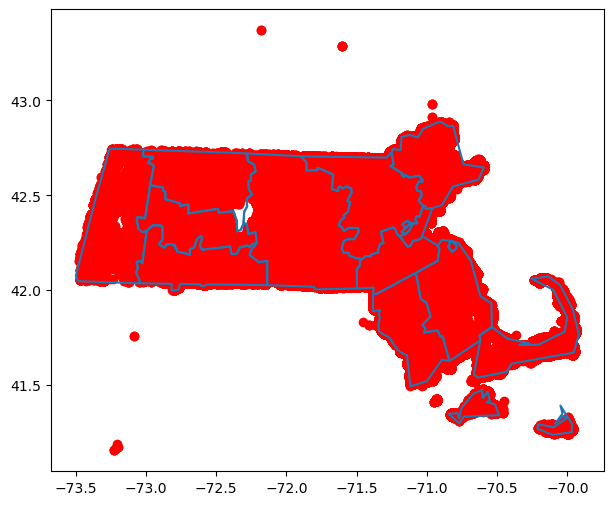

In [ ]:
# remove outliers
ma_voters_rmout_gdf = ma_voters_gdf.loc[
    ma_voters_gdf["Residence_Addresses_Longitude"] > -75
]

fig, ax = plt.subplots(figsize=(8, 6))
ma_counties_in_state_gdf.boundary.plot(ax=ax)
ma_voters_rmout_gdf.plot(ax=ax, color='red')
plt.show()

voters_pddf created! Next: counties_in_state_gdf...
counties_in_state_gdf created! Next: voters_gdf...


<AxesSubplot:>

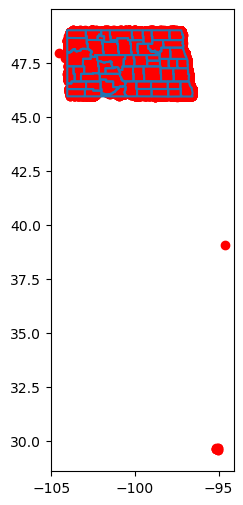

In [214]:
nd_voters_gdf, nd_counties_in_state_gdf = gen_state_gdf(dfnd, 'North Dakota')

fig, ax = plt.subplots(figsize=(10, 6))
nd_counties_in_state_gdf.boundary.plot(ax=ax)
nd_voters_gdf.plot(ax=ax, color='red')

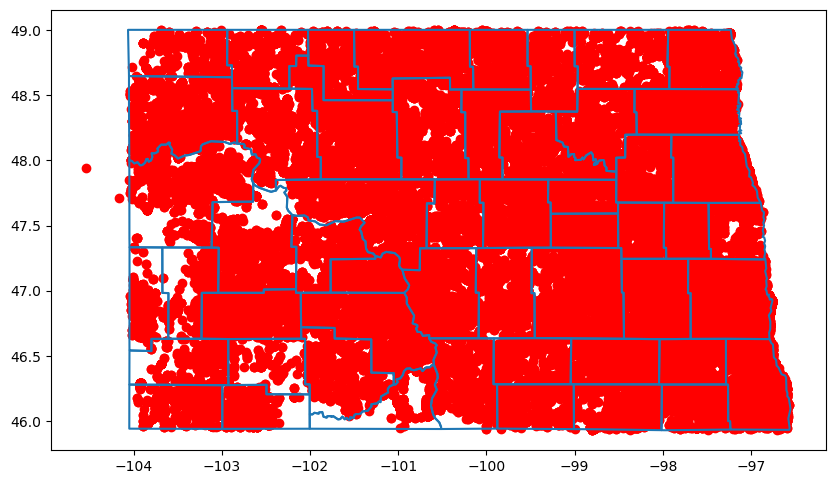

In [217]:
# remove outlier
nd_voters_rmout_gdf = nd_voters_gdf.loc[nd_voters_gdf["Residence_Addresses_Latitude"] > 45]
fig, ax = plt.subplots(figsize=(10, 6))
nd_counties_in_state_gdf.boundary.plot(ax=ax)
nd_voters_rmout_gdf.plot(ax=ax, color='red')
plt.show()

## Turnout model

In [15]:
# Import required libraries
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor

In [155]:
# select some variables we are interested in from the data
spark.conf.set("spark.sql.debug.maxToStringFields", 1000) 
df_need = df.select(
    "County", "Voters_Age", "Voters_Gender",
    "CommercialData_Education", "EthnicGroups_EthnicGroup1Desc",
    "CommercialData_EstimatedHHIncomeAmount", 
    "CommercialData_EstHomeValue",
    "ElectionReturns_G18CountyTurnoutAllRegisteredVoters"
)
# Drop missing values 
df_need = df_need.na.drop()

df_need.show(10)

+------+----------+-------------+------------------------+-----------------------------+--------------------------------------+---------------------------+---------------------------------------------------+
|County|Voters_Age|Voters_Gender|CommercialData_Education|EthnicGroups_EthnicGroup1Desc|CommercialData_EstimatedHHIncomeAmount|CommercialData_EstHomeValue|ElectionReturns_G18CountyTurnoutAllRegisteredVoters|
+------+----------+-------------+------------------------+-----------------------------+--------------------------------------+---------------------------+---------------------------------------------------+
|NAVAJO|        63|            F|     HS Diploma - Likely|                     European|                                  9000|                      12500|                                                 53|
|NAVAJO|        58|            M|    HS Diploma - Extr...|                        Other|                                  9000|                       7500|             

In [57]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import count


# Define the age groups or bins
splits = [17, 25, 35, 45, 55, 65, float("inf")]

# Create the Bucketizer object and set the input and output columns
bucketizer = Bucketizer(splits=splits, inputCol="Voters_Age", outputCol="AgeGroup")

# Apply the Bucketizer transformation to the dataframe
age_bucketed_df = bucketizer.transform(df_need)

# Group by county and age group and count the number of records in each group
counties_age_count_df = age_bucketed_df.groupBy("County", "AgeGroup").agg(count("*").alias("Count"))

# Pivot the data to have age groups as columns
age_pivot_df = counties_age_count_df.groupBy("County").pivot("AgeGroup").sum("Count")

# Rename the columns to reflect the age groups
age_groups = [
    "age18-25", "age26-35", "age36-45", "age46-55", "age56-65", "age66+"
]
for i in range(len(age_groups)):
    age_pivot_df = age_pivot_df.withColumnRenamed(
        str(float(i)), age_groups[i]
    )

age_pivot_df.show()

+----------+--------+--------+--------+--------+--------+------+
|    County|age18-25|age26-35|age36-45|age46-55|age56-65|age66+|
+----------+--------+--------+--------+--------+--------+------+
|      YUMA|    2452|    5981|    6821|    7060|    8335| 14603|
|  COCONINO|    1984|    4043|    5041|    5558|    6877| 10859|
|  GREENLEE|      89|     241|     296|     352|     388|   600|
|   COCHISE|    1354|    3475|    4694|    5225|    8112| 17116|
|    MOHAVE|    1582|    4365|    5481|    7154|   13474| 33306|
|SANTA CRUZ|     820|    1698|    1701|    2063|    2520|  4424|
|   YAVAPAI|    2028|    4969|    6521|    8693|   16249| 44347|
|      GILA|     377|     925|    1285|    1753|    3374|  8918|
|    LA PAZ|     119|     245|     300|     364|     599|  1452|
|    APACHE|     143|     478|     858|    1091|    1820|  3095|
|      PIMA|   14266|   35469|   40343|   45635|   62966|126401|
|    GRAHAM|     454|    1119|    1448|    1498|    1662|  3055|
|     PINAL|    4837|   1

In [58]:
# bucketize household income
splits = [-float("inf"), 50000, 100000, 150000, 200000, float("inf")]
bucketizer = Bucketizer(
    splits=splits, inputCol="CommercialData_EstimatedHHIncomeAmount", 
    outputCol="HHIncomeGroup"
)
income_bucketed_df = bucketizer.transform(df_need)
counties_income_count_df = income_bucketed_df.groupBy("County", "HHIncomeGroup") \
    .agg(count("*").alias("Count"))
income_pivot_df = counties_income_count_df.groupBy("County").pivot("HHIncomeGroup").sum("Count")

# rename columns
income_groups = [
    "inc0-50k", "inc50k-100k", "inc100k-150k", "inc150k-200k", "inc200k+"
]
for i in range(len(income_groups)):
    income_pivot_df = income_pivot_df.withColumnRenamed(
        str(float(i)), income_groups[i]
    )

income_pivot_df.show()

+----------+--------+-----------+------------+------------+--------+
|    County|inc0-50k|inc50k-100k|inc100k-150k|inc150k-200k|inc200k+|
+----------+--------+-----------+------------+------------+--------+
|      YUMA|   14834|      21199|        5981|        1681|    1557|
|  COCONINO|    7044|      14341|        7324|        2688|    2965|
|   COCHISE|   12552|      17862|        6545|        1608|    1409|
|  GREENLEE|     465|       1110|         279|          45|      67|
|    MOHAVE|   24260|      29423|        7197|        2238|    2244|
|SANTA CRUZ|    5730|       5236|        1356|         461|     443|
|   YAVAPAI|   22085|      38550|       12441|        4567|    5164|
|      GILA|    6610|       6863|        1850|         646|     663|
|    LA PAZ|    1488|       1199|         249|          61|      82|
|    APACHE|    3376|       3058|         720|         173|     158|
|      PIMA|   88456|     135292|       59159|       20441|   21732|
|    GRAHAM|    2750|       4614| 

In [122]:
# bucketize home value
splits = [-float("inf"), 50000, 100000, 150000, 200000, 250000, float("inf")]
bucketizer = Bucketizer(
    splits=splits, inputCol="CommercialData_EstHomeValue", 
    outputCol="HomeValueGroup"
)
homevalue_bucketed_df = bucketizer.transform(df_need)
counties_homevalue_count_df = homevalue_bucketed_df.groupBy("County", "HomeValueGroup") \
    .agg(count("*").alias("Count"))
homevalue_pivot_df = counties_homevalue_count_df.groupBy("County").pivot("HomeValueGroup").sum("Count")

# rename columns
homevalue_groups = [
    "hvalue0-50k", "hvalue50k-100k", "hvalue100k-150k", "hvalue150k-200k", 
    "hvalue200k-250k", "hvalue250k+"
]
for i in range(len(homevalue_groups)):
    homevalue_pivot_df = homevalue_pivot_df.withColumnRenamed(
        str(float(i)), homevalue_groups[i]
    )

homevalue_pivot_df.show()

+----------+-----------+--------------+---------------+---------------+---------------+-----------+
|    County|hvalue0-50k|hvalue50k-100k|hvalue100k-150k|hvalue150k-200k|hvalue200k-250k|hvalue250k+|
+----------+-----------+--------------+---------------+---------------+---------------+-----------+
|      YUMA|        688|          3120|          11375|          11108|           7609|      11352|
|  COCONINO|        319|          1599|           2109|           1685|           2246|      26404|
|   COCHISE|        814|          4673|           8675|          10170|           5863|       9781|
|  GREENLEE|        158|          1050|            553|             92|             47|         66|
|    MOHAVE|       1157|          5972|           7751|          11271|           8411|      30800|
|SANTA CRUZ|        142|           540|           2819|           4868|           2075|       2782|
|   YAVAPAI|        483|          1471|           4072|           7153|           7491|      62137|


In [68]:
# pivot education
edu_count_df = df_need.select("County", "CommercialData_Education") \
    .groupBy("County", "CommercialData_Education").agg(count("*").alias("Count"))
edu_pivot_df = edu_count_df.groupBy("County").pivot("CommercialData_Education").sum("Count")

edu_pivot_df.show(5)

+--------+------------------------------+--------------------+------------------------------+--------------------+-----------------------------+-------------------+------------------------------+-----------------------------+---------------------+------------------------------+----------------------------------------------+
|  County|Bach Degree - Extremely Likely|Bach Degree - Likely|Grad Degree - Extremely Likely|Grad Degree - Likely|HS Diploma - Extremely Likely|HS Diploma - Likely|Less than HS Diploma - Ex Like|Less than HS Diploma - Likely|Some College - Likely|Some College -Extremely Likely|Vocational Technical Degree - Extremely Likely|
+--------+------------------------------+--------------------+------------------------------+--------------------+-----------------------------+-------------------+------------------------------+-----------------------------+---------------------+------------------------------+----------------------------------------------+
|    YUMA|            

In [69]:
# combine columns in edu_pivot_df
edu_pivot_df = edu_pivot_df.withColumn(
    "Bach", 
    edu_pivot_df['Bach Degree - Extremely Likely'] + edu_pivot_df['Bach Degree - Likely']
)
edu_pivot_df = edu_pivot_df.withColumn(
    "Grad", 
    edu_pivot_df['Grad Degree - Extremely Likely'] + edu_pivot_df['Grad Degree - Likely']
)
edu_pivot_df = edu_pivot_df.withColumn(
    "HighSchool", 
    edu_pivot_df['HS Diploma - Extremely Likely'] + edu_pivot_df['HS Diploma - Likely']
)
edu_pivot_df = edu_pivot_df.withColumn(
    "LessHS", 
    edu_pivot_df['Less than HS Diploma - Ex Like'] + edu_pivot_df['Less than HS Diploma - Likely']
)
edu_pivot_df = edu_pivot_df.withColumn(
    "College", 
    edu_pivot_df['Some College - Likely'] + edu_pivot_df['Some College -Extremely Likely']
)
edu_pivot_df = edu_pivot_df.withColumn(
    "VocTech", 
    edu_pivot_df['Vocational Technical Degree - Extremely Likely']
)

edu_pivot_df = edu_pivot_df.select(
    "County",
    "Bach", "Grad", "HighSchool", "LessHS", 
    "College", "VocTech"
)
edu_pivot_df.show()

+----------+------+------+----------+------+-------+-------+
|    County|  Bach|  Grad|HighSchool|LessHS|College|VocTech|
+----------+------+------+----------+------+-------+-------+
|      YUMA|  9814|  3837|     12072|  6499|  12960|     70|
|  COCONINO|  9775|  6930|      7115|  1397|   9101|     44|
|   COCHISE|  9369|  5071|     10051|  2634|  12786|     65|
|  GREENLEE|   335|   109|       762|  null|    635|      7|
|    MOHAVE| 11587|  5109|     23065|  5043|  20404|    154|
|SANTA CRUZ|  3269|  1274|      4070|  null|   2861|     18|
|   YAVAPAI| 19338| 12185|     21784|  3941|  25450|    109|
|      GILA|  3442|  1856|      5335|  1183|   4786|     30|
|    LA PAZ|   498|   231|      1201|  null|    795|      9|
|    APACHE|  1546|   496|      2967|  null|   1821|     49|
|      PIMA| 85320| 58965|     74454| 16921|  88919|    501|
|    GRAHAM|  1969|   880|      2699|   621|   3053|     14|
|     PINAL| 25005| 11422|     33948|  7857|  38348|    176|
|    NAVAJO|  4476|  226

In [70]:
# pivot gender
gender_count_df = df_need.select("County", "Voters_Gender") \
    .groupBy("County", "Voters_Gender").agg(count("*").alias("Count"))
gender_pivot_df = gender_count_df.groupBy("County").pivot("Voters_Gender").sum("Count")

gender_pivot_df.show()

+----------+------+------+
|    County|     F|     M|
+----------+------+------+
|      YUMA| 23339| 21913|
|  COCONINO| 17841| 16521|
|   COCHISE| 20710| 19266|
|  GREENLEE|   985|   981|
|    MOHAVE| 33505| 31857|
|SANTA CRUZ|  6774|  6452|
|   YAVAPAI| 43911| 38896|
|      GILA|  8654|  7978|
|    LA PAZ|  1644|  1435|
|    APACHE|  4419|  3066|
|      PIMA|172745|152335|
|    GRAHAM|  4788|  4448|
|     PINAL| 60548| 56208|
|    NAVAJO| 11284|  9652|
|  MARICOPA|647374|584677|
+----------+------+------+



In [126]:
import copy


def count2ratio(pivot_df):
    """
    convert count to ratio
    """
    pivot_pddf = pivot_df.toPandas()
    pivot_arr = pivot_pddf.iloc[:, 1:].to_numpy()
    
    new_pivot_arr = copy.deepcopy(pivot_arr).astype('float')
    
    # calculate values in np.arr
    for rowi in range(pivot_arr.shape[0]):
        for colj in range(pivot_arr.shape[1]):
            new_pivot_arr[rowi, colj] = pivot_arr[rowi, colj] / np.nansum(pivot_arr[rowi, :])

    # update values in pd.df
    for rowi in range(pivot_pddf.shape[0]):
        pivot_pddf.iloc[rowi, 1:] = new_pivot_arr[rowi, :]

    new_pivot_df = spark.createDataFrame(pivot_pddf)
    
    return new_pivot_df

In [179]:
# convert count to ratio: age
age_ratio_pivot_df = count2ratio(age_pivot_df)
age_ratio_pivot_df.show()

+----------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|    County|            age18-25|           age26-35|           age36-45|           age46-55|           age56-65|             age66+|
+----------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|      YUMA|0.054185450366834614|0.13217095376999913|0.15073366923008927|0.15601520374790065| 0.1841907539998232|0.32270396888535313|
|  COCONINO| 0.05773819917350562| 0.1176590419649613| 0.1467027530411501|0.16174844304755254| 0.2001338688085676| 0.3160176939642628|
|   COCHISE| 0.03387032219331599|0.08692715629377627|0.11742045227136282|0.13070342205323193| 0.2029217530518311| 0.4281568941364819|
|  GREENLEE|0.045269582909460836|0.12258392675483215|  0.150559511698881| 0.1790437436419125|0.19735503560528994| 0.3051881993896236|
|SANTA CRUZ| 0.06199909269620445|0.12838348707092093|0.1286103

In [180]:
# convert count to ratio: gender
gender_ratio_pivot_df = count2ratio(gender_pivot_df)
gender_ratio_pivot_df.show()

+----------+------------------+-------------------+
|    County|                 F|                  M|
+----------+------------------+-------------------+
|      YUMA|0.5157562096702908| 0.4842437903297092|
|  COCONINO|0.5192072638379606|0.48079273616203944|
|   COCHISE|0.5180608365019012|0.48193916349809884|
|  GREENLEE|0.5010172939979655| 0.4989827060020346|
|    MOHAVE|0.5126067133808635| 0.4873932866191365|
|SANTA CRUZ|0.5121729925903523| 0.4878270074096477|
|   YAVAPAI|0.5302812564155204|0.46971874358447957|
|      GILA|0.5203222703222703| 0.4796777296777297|
|    LA PAZ|0.5339395907762261|0.46606040922377395|
|    APACHE|0.5903807615230461| 0.4096192384769539|
|      PIMA|0.5313922726713425| 0.4686077273286576|
|    GRAHAM|0.5184062364660026| 0.4815937635339974|
|     PINAL|0.5185857686114632| 0.4814142313885368|
|    NAVAJO|0.5389759266335499| 0.4610240733664501|
|  MARICOPA|0.5254441577499632| 0.4745558422500367|
+----------+------------------+-------------------+



In [181]:
# convert count to ratio: education
edu_ratio_pivot_df = count2ratio(edu_pivot_df)
edu_ratio_pivot_df.show()

+----------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+
|    County|               Bach|                Grad|         HighSchool|              LessHS|            College|             VocTech|
+----------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+
|      YUMA|0.21687439229205338| 0.08479183240519755|0.26677273932643863|  0.1436179616370547| 0.2863961813842482|0.001546892955007...|
|  COCONINO|0.28447121820615795| 0.20167627029858565| 0.2070601245561958| 0.04065537512368314| 0.2648565275595134|0.001280484255864...|
|   COCHISE|0.23436561937162298| 0.12685111066639984|  0.251425855513308| 0.06588953372023214|0.31984190514308586|0.001625975585351...|
|  GREENLEE| 0.1812770562770563|0.058982683982683984|0.41233766233766234|                 NaN| 0.3436147186147186|0.003787878787878788|
|    MOHAVE|0.17727425721367154| 0.0781646828432

In [182]:
# convert count to ratio: income
income_ratio_pivot_df = count2ratio(income_pivot_df)
income_ratio_pivot_df.show()

+----------+-------------------+-------------------+-------------------+--------------------+--------------------+
|    County|           inc0-50k|        inc50k-100k|       inc100k-150k|        inc150k-200k|            inc200k+|
+----------+-------------------+-------------------+-------------------+--------------------+--------------------+
|      YUMA| 0.3278087156368779|0.46846548218863254|0.13217095376999913| 0.03714752939096615|0.034407319013524264|
|  COCONINO|0.20499388859786974|0.41735056166695766|0.21314242477154996| 0.07822594726733019| 0.08628717769629242|
|   COCHISE| 0.3139883930358215| 0.4468180908545127|0.16372323394036423|0.040224134480688414|0.035246147688613165|
|  GREENLEE|0.23652085452695829| 0.5645981688708036|0.14191251271617497| 0.02288911495422177|  0.0340793489318413|
|    MOHAVE|0.37116367308221904|0.45015452403537226|0.11010984975979927| 0.03424007833297635| 0.03433187478963312|
|SANTA CRUZ|0.43323756237713595|0.39588688946015427|0.10252532889762589| 0.03485

In [183]:
# convert count to ratio: homevalue
homevalue_ratio_pivot_df = count2ratio(homevalue_pivot_df)
homevalue_ratio_pivot_df.show()

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+
|    County|         hvalue0-50k|      hvalue50k-100k|    hvalue100k-150k|     hvalue150k-200k|     hvalue200k-250k|        hvalue250k+|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+
|      YUMA|0.015203747900645275| 0.06894722885176346|0.25137010518872094| 0.24546981348890656| 0.16814726420931672|0.25086184036064707|
|  COCONINO|0.009283510855014259|0.046533961934695306|0.06137593853675572|0.049036726616611376| 0.06536290087887783| 0.7684069611780455|
|   COCHISE| 0.02036221733039824| 0.11689513708224936|0.21700520312187313| 0.25440264158495096|  0.1466629977986792| 0.2446718030818491|
|  GREENLEE| 0.08036622583926754|  0.5340793489318413| 0.2812817904374364| 0.04679552390640895|0.023906408952187184| 0.0335707019328586|
|    MOHAVE|0.017701416725314403| 0.09136

In [184]:
# turnout by county
turnout_df = df_need.select("County", "ElectionReturns_G18CountyTurnoutAllRegisteredVoters")
turnout_df = turnout_df.groupBy("County").agg(
    mean("ElectionReturns_G18CountyTurnoutAllRegisteredVoters").alias(
        "G18Turnout"
    )
)
turnout_df.show()

+----------+----------+
|    County|G18Turnout|
+----------+----------+
|      YUMA|      43.0|
|  COCONINO|      61.0|
|   COCHISE|      60.0|
|  GREENLEE|      56.0|
|    MOHAVE|      53.0|
|SANTA CRUZ|      47.0|
|   YAVAPAI|      73.0|
|      GILA|      66.0|
|    APACHE|      48.0|
|    LA PAZ|      47.0|
|      PIMA|      67.0|
|    GRAHAM|      57.0|
|     PINAL|      59.0|
|    NAVAJO|      53.0|
|  MARICOPA|      62.0|
+----------+----------+



In [186]:
# rename county columns
age_ratio_pivot_df = age_ratio_pivot_df.withColumn(
    "ageCounty", age_ratio_pivot_df["County"]
)
age_ratio_pivot_df = age_ratio_pivot_df.drop("County")
edu_ratio_pivot_df = edu_ratio_pivot_df.withColumn(
    "eduCounty", edu_ratio_pivot_df["County"]
)
edu_ratio_pivot_df = edu_ratio_pivot_df.drop("County")
income_ratio_pivot_df = income_ratio_pivot_df.withColumn(
    "incCounty", income_ratio_pivot_df["County"]
)
income_ratio_pivot_df = income_ratio_pivot_df.drop("County")
homevalue_ratio_pivot_df = homevalue_ratio_pivot_df.withColumn(
    "hvalCounty", homevalue_ratio_pivot_df["County"]
)
homevalue_ratio_pivot_df = homevalue_ratio_pivot_df.drop("County")
turnout_df = turnout_df.withColumn(
    "toutCounty", turnout_df["County"]
)
turnout_df = turnout_df.drop("County")

In [194]:
# join pivot tables
joined_pivot_df = gender_ratio_pivot_df.join(
    age_ratio_pivot_df, gender_ratio_pivot_df.County==age_ratio_pivot_df.ageCounty,
    "inner"
)
joined_pivot_df = joined_pivot_df.join(
    edu_ratio_pivot_df, joined_pivot_df.County==edu_ratio_pivot_df.eduCounty,
    "inner"
)
joined_pivot_df = joined_pivot_df.join(
    income_ratio_pivot_df, joined_pivot_df.County==income_ratio_pivot_df.incCounty,
    "inner"
)
joined_pivot_df = joined_pivot_df.join(
    homevalue_ratio_pivot_df, joined_pivot_df.County==homevalue_ratio_pivot_df.hvalCounty,
    "inner"
)
joined_pivot_df = joined_pivot_df.join(
    turnout_df, joined_pivot_df.County==turnout_df.toutCounty,
    "inner"
)

# drop additional county columns
joined_pivot_df = joined_pivot_df.drop(
    "ageCounty", "eduCounty", "incCounty", "hvalCounty", "toutCounty"
)

joined_pivot_df.printSchema()

root
 |-- County: string (nullable = true)
 |-- F: double (nullable = true)
 |-- M: double (nullable = true)
 |-- age18-25: double (nullable = true)
 |-- age26-35: double (nullable = true)
 |-- age36-45: double (nullable = true)
 |-- age46-55: double (nullable = true)
 |-- age56-65: double (nullable = true)
 |-- age66+: double (nullable = true)
 |-- Bach: double (nullable = true)
 |-- Grad: double (nullable = true)
 |-- HighSchool: double (nullable = true)
 |-- LessHS: double (nullable = true)
 |-- College: double (nullable = true)
 |-- VocTech: double (nullable = true)
 |-- inc0-50k: double (nullable = true)
 |-- inc50k-100k: double (nullable = true)
 |-- inc100k-150k: double (nullable = true)
 |-- inc150k-200k: double (nullable = true)
 |-- inc200k+: double (nullable = true)
 |-- hvalue0-50k: double (nullable = true)
 |-- hvalue50k-100k: double (nullable = true)
 |-- hvalue100k-150k: double (nullable = true)
 |-- hvalue150k-200k: double (nullable = true)
 |-- hvalue200k-250k: double 

In [200]:
joined_pivot_df = joined_pivot_df.na.fill(value=0)

In [201]:
# Create vector assembler to combine all features
assembler = VectorAssembler(
    inputCols=joined_pivot_df.schema.names[1:-1],
    outputCol="features"
)

In [203]:
# Create random forest regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="G18Turnout")

# Create a pipeline for all transformations and the model
pipeline = Pipeline(stages=[assembler, rf])

# Split the data into training and testing sets
(train_data, test_data) = joined_pivot_df.randomSplit([0.7, 0.3], seed=100)

# Fit the pipeline to the training data
model = pipeline.fit(train_data)

# Make predictions on the testing data
predictions = model.transform(test_data)

23/03/20 19:31:30 WARN org.apache.spark.ml.tree.impl.DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 10 (= number of training instances)


In [204]:
predictions.show()

+--------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+----------+--------------------+-----------------+
|  County|                 F|                  M|            age18-25|           age26-35|           age36-45|           age46-55|           age56-65|            age66+|               Bach|                Grad|         HighSchool|             LessHS|            College|             VocTech|           inc0-50k|        inc50k-100k|       inc100k-150k|        inc150k-200k|            inc200k+|         hvalue0-50k|     hvalue50k-100k|

In [206]:
# Evaluate the performance of the model on the test data
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

evaluator = RegressionEvaluator(
    labelCol="G18Turnout", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)

print(f"RMSE on the test data: {rmse}")

RMSE on the test data: 9.27969707359986
